In [1]:
import keras

backbone = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180,180, 3))

backbone.summary()

2023-09-13 15:34:23.377737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-09-13 15:34:24.812527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-13 15:34:24.829852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-13 15:34:24.830278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

58889256/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

In [2]:
import pathlib
from keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path("cat_vs_dogs_small")

train_dataset = image_dataset_from_directory(
    directory=new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    directory=new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    directory=new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [3]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = backbone.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
valid_features, valid_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)


2023-09-13 15:42:41.563257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2023-09-13 15:42:41.983452: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 13ms/step


In [4]:
train_features.shape

(2000, 5, 5, 512)

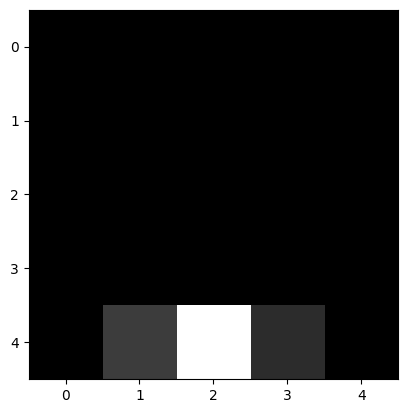

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_feature = train_features[0, :, :, 0].reshape((5, 5))
plt.imshow(sample_feature, cmap="gray")
_ = plt.show()

In [9]:
from keras import layers

inputs = keras.Input(shape=(5, 5, 512))

x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.x",
        save_best=True,
        monitor="val_loss")
]

history = model.fit(
    train_features,
    train_labels,
    epochs=20,
    validation_data=(valid_features, valid_labels),
    callbacks=callbacks)

Epoch 1/20


2023-09-13 15:53:19.348034: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561ba1649d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-13 15:53:19.348059: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-09-13 15:53:19.351348: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-13 15:53:19.391668: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-13 15:53:19.427691: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/63 [============================>.] - ETA: 0s - loss: 20.3191 - accuracy: 0.9185INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 13ms/step - loss: 19.8920 - accuracy: 0.9200 - val_loss: 3.9687 - val_accuracy: 0.9670
Epoch 2/20
56/63 [=========================>....] - ETA: 0s - loss: 2.4755 - accuracy: 0.9794  INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 0s 8ms/step - loss: 2.7511 - accuracy: 0.9785 - val_loss: 4.9852 - val_accuracy: 0.9650
Epoch 3/20
46/63 [====================>.........] - ETA: 0s - loss: 1.9938 - accuracy: 0.9851INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 8ms/step - loss: 2.6055 - accuracy: 0.9825 - val_loss: 4.7623 - val_accuracy: 0.9680
Epoch 4/20
49/63 [======================>.......] - ETA: 0s - loss: 0.9832 - accuracy: 0.9923  INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 8ms/step - loss: 1.0214 - accuracy: 0.9910 - val_loss: 4.3783 - val_accuracy: 0.9720
Epoch 5/20
47/63 [=====================>........] - ETA: 0s - loss: 0.8051 - accuracy: 0.9960  INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 8ms/step - loss: 1.4479 - accuracy: 0.9900 - val_loss: 6.9810 - val_accuracy: 0.9600
Epoch 6/20
63/63 [==============================] - ETA: 0s - loss: 0.9698 - accuracy: 0.9930  INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 8ms/step - loss: 0.9698 - accuracy: 0.9930 - val_loss: 4.3677 - val_accuracy: 0.9710
Epoch 7/20
48/63 [=====================>........] - ETA: 0s - loss: 0.3940 - accuracy: 0.9948  INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 8ms/step - loss: 0.3216 - accuracy: 0.9955 - val_loss: 5.1785 - val_accuracy: 0.9680
Epoch 8/20
48/63 [=====================>........] - ETA: 0s - loss: 0.0860 - accuracy: 0.9980  INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 10ms/step - loss: 0.0660 - accuracy: 0.9985 - val_loss: 4.1926 - val_accuracy: 0.9750
Epoch 9/20
45/63 [====================>.........] - ETA: 0s - loss: 0.5862 - accuracy: 0.9951  INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 8ms/step - loss: 0.4626 - accuracy: 0.9960 - val_loss: 4.1859 - val_accuracy: 0.9790
Epoch 10/20
49/63 [======================>.......] - ETA: 0s - loss: 0.0660 - accuracy: 0.9987    INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 8ms/step - loss: 0.1203 - accuracy: 0.9980 - val_loss: 5.1154 - val_accuracy: 0.9740
Epoch 11/20
49/63 [======================>.......] - ETA: 0s - loss: 0.2844 - accuracy: 0.9974  INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 8ms/step - loss: 0.2441 - accuracy: 0.9975 - val_loss: 4.7339 - val_accuracy: 0.9720
Epoch 12/20
49/63 [======================>.......] - ETA: 0s - loss: 0.1612 - accuracy: 0.9962    INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 8ms/step - loss: 0.1264 - accuracy: 0.9970 - val_loss: 5.1739 - val_accuracy: 0.9760
Epoch 13/20
46/63 [====================>.........] - ETA: 0s - loss: 0.1821 - accuracy: 0.9986    INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 8ms/step - loss: 0.1340 - accuracy: 0.9990 - val_loss: 5.4102 - val_accuracy: 0.9720
Epoch 14/20
63/63 [==============================] - ETA: 0s - loss: 0.1004 - accuracy: 0.9980INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 9ms/step - loss: 0.1004 - accuracy: 0.9980 - val_loss: 4.3463 - val_accuracy: 0.9770
Epoch 15/20
43/63 [===================>..........] - ETA: 0s - loss: 2.1969e-15 - accuracy: 1.0000INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 8ms/step - loss: 0.0624 - accuracy: 0.9990 - val_loss: 4.6607 - val_accuracy: 0.9780
Epoch 16/20
49/63 [======================>.......] - ETA: 0s - loss: 1.7293e-09 - accuracy: 1.0000INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 8ms/step - loss: 1.3558e-09 - accuracy: 1.0000 - val_loss: 4.6610 - val_accuracy: 0.9780
Epoch 17/20
52/63 [=======================>......] - ETA: 0s - loss: 0.2903 - accuracy: 0.9964  INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 8ms/step - loss: 0.2681 - accuracy: 0.9965 - val_loss: 6.3270 - val_accuracy: 0.9690
Epoch 18/20
48/63 [=====================>........] - ETA: 0s - loss: 0.1915 - accuracy: 0.9954  INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 8ms/step - loss: 0.2255 - accuracy: 0.9955 - val_loss: 4.3391 - val_accuracy: 0.9760
Epoch 19/20
53/63 [========================>.....] - ETA: 0s - loss: 6.1860e-11 - accuracy: 1.0000INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 0s 8ms/step - loss: 0.0176 - accuracy: 0.9995 - val_loss: 9.7421 - val_accuracy: 0.9580
Epoch 20/20
57/63 [==========================>...] - ETA: 0s - loss: 0.2583 - accuracy: 0.9973  INFO:tensorflow:Assets written to: feature_extraction.x/assets


INFO:tensorflow:Assets written to: feature_extraction.x/assets


63/63 [==============================] - 1s 10ms/step - loss: 0.2701 - accuracy: 0.9970 - val_loss: 5.5118 - val_accuracy: 0.9760


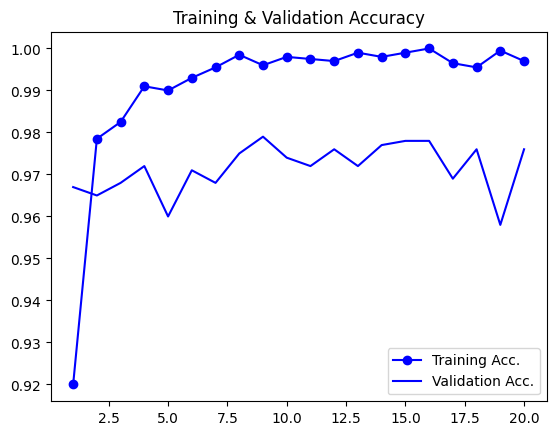

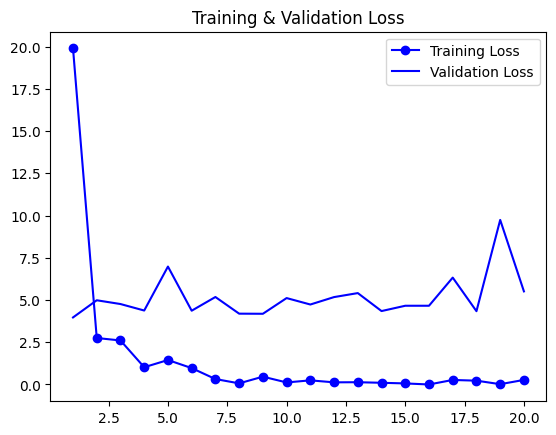

In [12]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo-", label="Training Acc.")
plt.plot(epochs, val_acc, "b", label="Validation Acc.")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo-", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()